In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os.path
import ast

In [176]:
matplotlib.rcParams['figure.figsize'] = (12, 10) 
# pd.set_option('display.max_rows', 1000)

## Introduction


This notebook uses data that describes vaiour features of Python source code to evaluate whether machine learning models can predict the status of mutations without the full length process of generating and executing the testing suit on every mutation.


|	Features Number	|	Abbreviation	|	Description	|
|-------------------|-------------------|---------------|
|	0	|	source_file	|	Source file where mutations occur.	|
|	1	|	mutation_number	|	Mutation identified.	|
|	2	|	mutant_operator_type	|	Type of mutation operator.	|
|	3	|	lineno	|	Line number where mutation occurs.	|
|	4	|	ast_depth	|	Current depth in the AST of the mutation.	|
|	5	|	num_test_cover	|	Number of assert tests that cover the mutation.	|
|	6	|	num_executed	|	Number of times the mutated statement was executed in all tests.	|
|	7	|	num_assert_tm	|	Number of asserts in all test methods that cover the mutation.	|
|	8	|	num_assert_tc	|	Number of asserts in all test cases that cover the mutation.	|
|	9	|	function_max_depth	|	The maximum depth of a test function that covers the mutation.	|
|	10	|	function_avg_depth	|	The average depth test functions that cover the mutation.	|
|	11	|	class_max_depth	|	The maximum depth of a class function that covers the mutation.	|
|	12	|	lineno_loc	|	The cumulative lines of code in test functions that cover the mutation.	|
|	13	|	loc_list	|	A location list used for further evaluation. 	|
|	14	|	status	|	Describes whether the mutation status from MutPy testing.	|


Other features are generated in this notebook such as one-hot encoding for mutant operator types.

## Data Exploration

In [177]:
data_file = 'CSV/bitstring_data.csv'

if not os.path.exists(data_file):
    print('Cannot find data')

data2_file = 'CSV/dictset_data.csv'

if not os.path.exists(data2_file):
    print('Cannot find data')

In [178]:
bs_df = pd.read_csv('CSV/bitstring_data.csv', sep=',', header=0)
ds_df = pd.read_csv('CSV/dictset_data.csv', sep=',', header=0)

frames = [bs_df, ds_df]

bs_df = pd.concat(frames)

In [179]:
bs_df.head()

,source_file,mutation_number,mutant_operator_type,lineno,ast_depth,num_test_cover,num_executed,num_assert_tm,num_assert_tc,function_max_depth,function_avg_depth,class_max_depth,lineno_loc,loc_list,status
0,bitstring.py,1,AOD,216,8,24,57,97,1094,7,6.333333,11,233,"['103:109', '53:56', '224:234', '191:202', '16...",killed
1,bitstring.py,2,AOD,218,7,24,57,97,1094,7,6.333333,11,233,"['103:109', '53:56', '224:234', '191:202', '16...",killed
2,bitstring.py,3,AOD,464,8,0,0,0,0,0,0.000000,0,0,[],survived
3,bitstring.py,4,AOD,467,9,1,256,0,0,0,0.000000,0,0,[],killed
4,bitstring.py,5,AOD,533,10,6,127,51,610,8,7.333333,11,64,"['3080:3091', '2483:2489', '2439:2459', '2461:...",killed


In [180]:
bs_df.tail()

,source_file,mutation_number,mutant_operator_type,lineno,ast_depth,num_test_cover,num_executed,num_assert_tm,num_assert_tc,function_max_depth,function_avg_depth,class_max_depth,lineno_loc,loc_list,status
306,dictset.py,307,SCI,561,2,0,0,0,0,0,0.0,0,0,[],incompetent
307,dictset.py,308,SCI,576,2,0,0,0,0,0,0.0,0,0,[],incompetent
308,dictset.py,309,SCI,593,2,0,0,0,0,0,0.0,0,0,[],survived
309,dictset.py,310,SCI,635,2,0,0,0,0,0,0.0,0,0,[],survived
310,dictset.py,311,SCI,697,2,0,0,0,0,0,0.0,0,0,[],incompetent


In [181]:
bs_df.describe()

,mutation_number,lineno,ast_depth,num_test_cover,num_executed,num_assert_tm,num_assert_tc,function_max_depth,function_avg_depth,class_max_depth,lineno_loc
count,4210.000000,4210.000000,4210.000000,4210.000000,4.210000e+03,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000
mean,1817.474109,1679.898575,5.988124,33.625891,3.012746e+03,140.263658,535.920190,6.939430,5.654377,8.369359,264.846081
std,1180.838915,1155.124087,2.276002,74.796929,6.768255e+04,286.384633,495.280262,3.509399,2.719214,4.124305,527.435386
min,1.000000,7.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,742.250000,576.250000,4.000000,1.000000,2.000000e+00,4.000000,18.000000,7.000000,6.250000,7.000000,8.000000
50%,1794.500000,1524.000000,6.000000,7.000000,2.100000e+01,34.000000,508.000000,8.000000,6.786348,11.000000,64.000000
75%,2846.750000,2530.750000,7.000000,25.000000,1.140000e+02,127.000000,872.000000,9.000000,7.000000,11.000000,246.000000
max,3899.000000,4296.000000,17.000000,477.000000,2.359296e+06,1707.000000,1739.000000,11.000000,11.000000,11.000000,3074.000000


In [182]:
bs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4210 entries, 0 to 310
Data columns (total 15 columns):
source_file             4210 non-null object
mutation_number         4210 non-null int64
mutant_operator_type    4210 non-null object
lineno                  4210 non-null int64
ast_depth               4210 non-null int64
num_test_cover          4210 non-null int64
num_executed            4210 non-null int64
num_assert_tm           4210 non-null int64
num_assert_tc           4210 non-null int64
function_max_depth      4210 non-null int64
function_avg_depth      4210 non-null float64
class_max_depth         4210 non-null int64
lineno_loc              4210 non-null int64
loc_list                4210 non-null object
status                  4210 non-null object
dtypes: float64(1), int64(10), object(4)
memory usage: 526.2+ KB


## Data Cleaning

In [183]:
bs_df.isnull().values.any()

False

In [184]:
bs_df['status'].value_counts()

killed         2978
survived        963
incompetent     222
timeout          47
Name: status, dtype: int64

In [185]:
bs_df = bs_df[bs_df.status != 'incompetent']
bs_df = bs_df[bs_df.status != 'timeout']
bs_df['status'].value_counts()

killed      2978
survived     963
Name: status, dtype: int64

In [186]:
bs_df['mutant_operator_type'].value_counts()

CRP    1782
AOR     562
ROR     491
COI     470
LOR     139
COD     123
ASR      75
SIR      54
EXS      45
LCR      40
AOD      36
IHD      27
IOD      27
EHD      27
SCI      25
BCR      10
LOD       7
DDL       1
Name: mutant_operator_type, dtype: int64

In [187]:
one_hot= pd.get_dummies(bs_df['mutant_operator_type'])
bs_df = bs_df.drop('mutant_operator_type',axis = 1)
bs_df = bs_df.join(one_hot)
bs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395 entries, 0 to 3898
Data columns (total 32 columns):
source_file           4395 non-null object
mutation_number       4395 non-null int64
lineno                4395 non-null int64
ast_depth             4395 non-null int64
num_test_cover        4395 non-null int64
num_executed          4395 non-null int64
num_assert_tm         4395 non-null int64
num_assert_tc         4395 non-null int64
function_max_depth    4395 non-null int64
function_avg_depth    4395 non-null float64
class_max_depth       4395 non-null int64
lineno_loc            4395 non-null int64
loc_list              4395 non-null object
status                4395 non-null object
AOD                   4395 non-null uint8
AOR                   4395 non-null uint8
ASR                   4395 non-null uint8
BCR                   4395 non-null uint8
COD                   4395 non-null uint8
COI                   4395 non-null uint8
CRP                   4395 non-null uint8
DDL   

In [188]:
X_bs = bs_df.drop(labels=['source_file','mutation_number', 'loc_list', 'status'], axis=1)
y_bs = bs_df[['status']]

In [189]:
X_bs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395 entries, 0 to 3898
Data columns (total 28 columns):
lineno                4395 non-null int64
ast_depth             4395 non-null int64
num_test_cover        4395 non-null int64
num_executed          4395 non-null int64
num_assert_tm         4395 non-null int64
num_assert_tc         4395 non-null int64
function_max_depth    4395 non-null int64
function_avg_depth    4395 non-null float64
class_max_depth       4395 non-null int64
lineno_loc            4395 non-null int64
AOD                   4395 non-null uint8
AOR                   4395 non-null uint8
ASR                   4395 non-null uint8
BCR                   4395 non-null uint8
COD                   4395 non-null uint8
COI                   4395 non-null uint8
CRP                   4395 non-null uint8
DDL                   4395 non-null uint8
EHD                   4395 non-null uint8
EXS                   4395 non-null uint8
IHD                   4395 non-null uint8
IOD      

In [190]:
m = X_bs.shape[0]
n = X_bs.shape[1]
print('m = ', m)
print('n = ', n)

m =  4395
n =  28


In [191]:
y_bs = y_bs.replace({'killed':0})
y_bs = y_bs.replace({'survived':1})

In [192]:
X_bs = X_bs.astype(float)

In [193]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X_bs))

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bs, test_size=0.25, random_state=42)

## Algorithm Implementation

In [195]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)


In [196]:
rnd_clf.fit(X_train, np.ravel(y_train))
y_pred = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.8689717925386715


In [197]:
print(rnd_clf.feature_importances_)

[9.29247842e-02 1.47268622e-01 1.16485865e-01 1.58765661e-01
 9.51350124e-02 5.13441305e-02 4.91753573e-02 4.69065390e-02
 3.44453249e-02 1.46038332e-01 5.13878484e-04 3.21481108e-03
 5.71896149e-04 7.13618932e-04 4.64777888e-04 5.10279203e-03
 3.61828089e-02 0.00000000e+00 1.06198767e-04 6.14729343e-04
 1.05568353e-03 3.50161668e-03 6.36503247e-05 2.45266484e-05
 5.87870521e-04 1.62807066e-03 6.85765137e-03 3.05790016e-04]


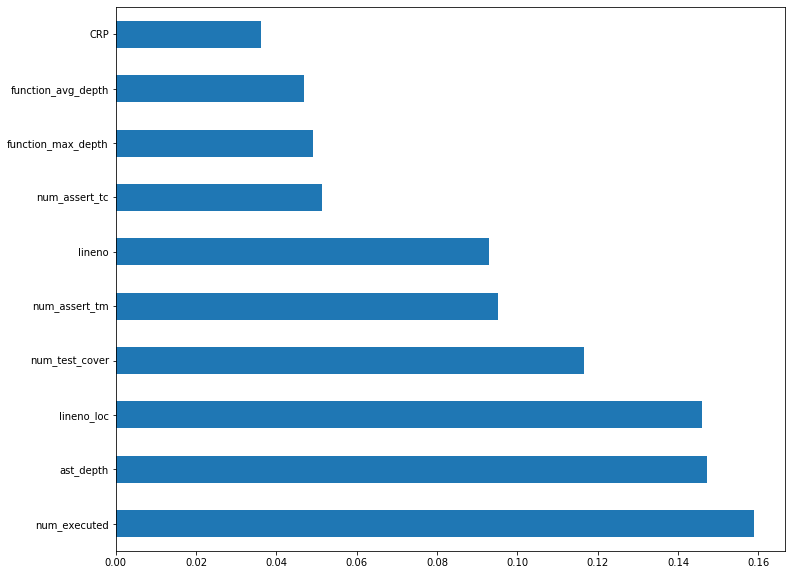

In [198]:
feat_importances = pd.Series(rnd_clf.feature_importances_, index=X_bs.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [78]:
for i in range(len(rnd_clf.feature_importances_)):
    print(rnd_clf.feature_importances_[i])

0.094429677998156
0.14359731777976176
0.10200948994734034
0.1625965932746229
0.0924568806864417
0.05362127219919794
0.0548768538506476
0.043440483060674225
0.03493285543237355
0.1553556483471262
0.0006484857631407396
0.002484014161081319
0.0005133560581489427
0.0007592525401415972
0.00043227677455253414
0.004196436565592057
0.040055755709151875
0.0
8.067963644039212e-05
0.0007666418785028203
0.0010223146495225157
0.0035651419634007827
7.525126755816786e-05
3.569378647789848e-05
0.000683364586650878
0.001241638871423491
0.005920683769557275
0.00020193944231465644


In [150]:
for i in range(len(rnd_clf.feature_importances_)):
    print(rnd_clf.feature_importances_[i])

0.0970881245053331
0.15230580554099638
0.11313359836897265
0.16320737338308391
0.09443846139442676
0.051614091152778624
0.04087072553875492
0.043537733066554785
0.028475643647204854
0.15396962587488874
0.0007561914134823827
0.003078094064983573
0.0006908673792513069
0.0006999064068815519
0.0003459799452447773
0.0049581206806414676
0.035736979000326706
0.0
0.00017332491632110846
0.0008437960162510575
0.0011649294623315863
0.0035785654273953367
4.68655383693667e-05
4.317298038093264e-05
0.0005270811143818356
0.0013944522077180533
0.006852478456882865
0.0004680125161613239


In [80]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [81]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
3077,0.642290,1.249531,-0.335248,-0.045264,-0.366282,0.351538,0.004473,0.312350,0.642785,-0.384220,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
2011,-1.026720,-0.475516,-0.080872,-0.044325,0.074619,1.040956,0.582630,0.450855,0.642785,0.110568,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
6,-1.308624,1.680792,-0.442354,-0.045674,-0.485255,-1.015271,0.871708,1.591313,0.396637,-0.497965,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
932,-0.892234,0.818269,0.869694,0.036802,0.477028,-0.450109,0.582630,0.616150,0.150489,0.518152,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
439,-1.357763,0.387007,-0.455743,-0.045704,-0.492253,-1.059362,-2.019076,-2.121806,-2.064841,-0.505548,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,1.731973,1.680792,-0.428966,-0.045586,-0.471258,-0.840913,-0.284606,0.106065,0.396637,-0.488486,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
466,-1.310348,0.818269,-0.442354,-0.045674,-0.485255,-1.015271,0.871708,1.591313,0.396637,-0.497965,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
3092,0.649186,1.249531,-0.281695,-0.044237,-0.320792,0.596041,0.004473,0.363128,0.642785,-0.338723,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,-0.188626,-0.369911,-0.082903,-0.111533
3772,-1.149999,-0.044255,-0.362025,-0.044384,-0.401274,0.002822,0.004473,0.424333,0.642785,-0.408865,...,-0.0815,-0.108353,-0.078621,-0.089596,-0.095838,-0.039941,5.301505,-0.369911,-0.082903,-0.111533


In [125]:
X_bs.columns

Index(['lineno', 'ast_depth', 'num_test_cover', 'num_executed',
       'num_assert_tm', 'num_assert_tc', 'function_max_depth',
       'function_avg_depth', 'class_max_depth', 'lineno_loc', 'AOD', 'AOR',
       'ASR', 'BCR', 'COD', 'COI', 'CRP', 'DDL', 'EHD', 'EXS', 'IHD', 'IOD',
       'LCR', 'LOD', 'LOR', 'ROR', 'SCI', 'SIR'],
      dtype='object')